In [1]:
import os
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps
import re
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from keras.layers import MaxPooling3D, \
    Input, ConvLSTM2D, UpSampling2D, \
    MaxPooling2D, Conv2D, Concatenate, Conv3D, \
    Dropout, BatchNormalization, Add, MaxPool2D, Conv2DTranspose, MaxPool3D, Conv3DTranspose, UpSampling3D, \
    concatenate, MaxPooling3D, Bidirectional, TimeDistributed, Reshape, Flatten
from tensorflow.python.client import device_lib
import random
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from keras import backend as K
import natsort
import cv2


2021-11-02 09:43:33.102990: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:

########################################################################################################################
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '-1'
print(device_lib.list_local_devices())



[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8544417216490746927
]


2021-11-02 09:43:35.283881: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-02 09:43:35.288027: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-02 09:43:35.321994: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-11-02 09:43:35.322689: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: rexio
2021-11-02 09:43:35.323084: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: rexio
2021-11-02 09:43:35.323336: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:20

In [45]:

def to_FFT(x):
    x = tf.cast(x, tf.complex64)
    x = tf.compat.v1.spectral.fft(x)
    x = tf.cast(x, tf.float32)
    return x


def to_inverse_FFT(x):
    x = tf.cast(x, tf.complex64)
    x = tf.compat.v1.spectral.irfft(x)
    x = tf.cast(x, tf.float32)
    return x



In [50]:

####################################################################################################################
# Load dataset
####################################################################################################################
dataset_path = '/home/aijjeh/Desktop/Phd_Project/GT_RMS_waves/Dataset/'
os.chdir(dataset_path)
dataset_x_GT = np.load('GT2RMS2waves_Training_x_thresholded_augmented_h_v_d_RGB.npy', mmap_mode='r')
dataset_y_RMS = np.load('GT2RMS2waves_Labels_y_augmented_h_v_d_RGB.npy', mmap_mode='r')

imgx= dataset_y_RMS[0]

dataset_x_GT = np.reshape(dataset_x_GT,
                          (dataset_x_GT.shape[0],
                           dataset_x_GT.shape[1] * dataset_x_GT.shape[2],
                           dataset_x_GT.shape[3]))
dataset_y_RMS = np.reshape(dataset_y_RMS,
                           (dataset_y_RMS.shape[0],
                            dataset_y_RMS.shape[1] * dataset_y_RMS.shape[2],
                            dataset_y_RMS.shape[3]))
####################################################################################################################


In [51]:
x_train = dataset_x_GT[:1216]
y_train = dataset_y_RMS[:1216]
x_val = dataset_x_GT[1216:1520]
y_val = dataset_y_RMS[1216:1520]
x_test = dataset_x_GT[1520:]
y_test = dataset_y_RMS[1520:]


In [52]:
print(y_train.shape)

(1216, 262144, 3)


[[0.43529412 0.43529412 0.43529412]
 [0.38431373 0.38431373 0.38431373]
 [0.31764707 0.31764707 0.31764707]
 ...
 [0.31764707 0.31764707 0.31764707]
 [0.38431373 0.38431373 0.38431373]
 [0.43529412 0.43529412 0.43529412]]


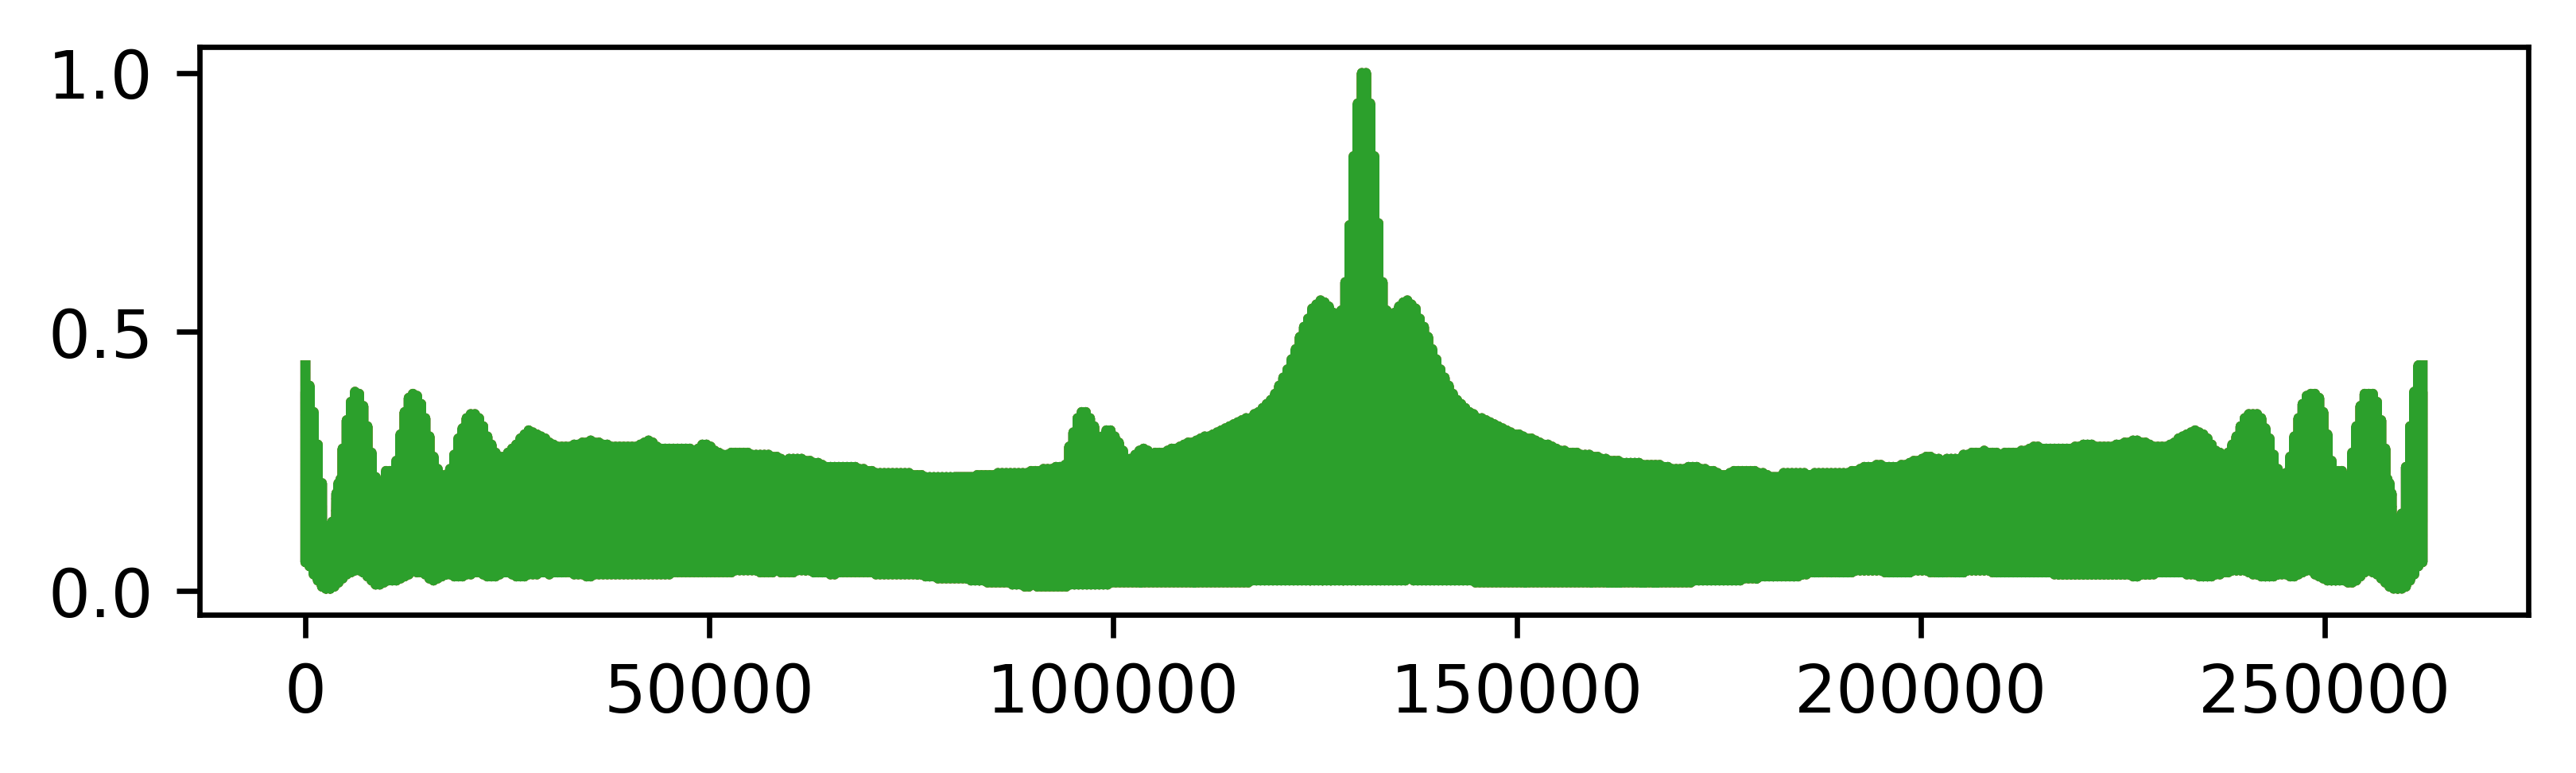

In [53]:
diff = (y_train[0][:]) # - (y_train[0][131072:]
plt.figure(figsize=(16 / 2.54, 4 / 2.54), dpi=600)
print(diff)
plt.plot(diff)
plt.show()

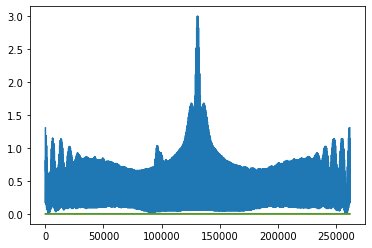

In [77]:
fft_img = to_FFT(diff)
plt.plot(fft_img)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


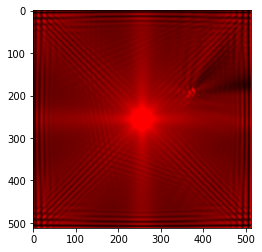

In [78]:
fft_img = tf.reshape(fft_img,(512,512,3))
plt.imshow(fft_img)
plt.show()

In [161]:
def fft_2d(x):
    x = tf.cast(x, tf.complex64)
    x = tf.transpose(x, (2, 0, 1))
    x = tf.compat.v1.spectral.fft2d(x)
    # x = tf.signal.fftshift(x)
    x = tf.transpose(x, (1, 2 ,0))
    x = tf.compat.v1.real(x)
    return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


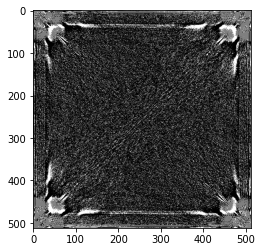

In [162]:
img = fft_2d(imgx)
plt.imshow(img)
plt.show()

In [163]:
def ifft_2d(x):
    x = tf.cast(x, tf.complex64)
    x = tf.transpose(x, (2, 0, 1))
    # x = tf.signal.ifftshift(x)
    x = tf.compat.v1.spectral.ifft2d(x)
    x = tf.transpose(x, (1, 2 ,0))
    x = tf.compat.v1.real(x)
    return x

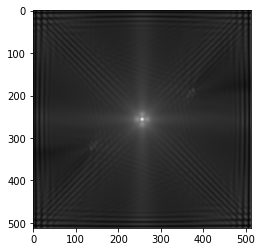

(512, 512, 3)


In [164]:
img = ifft_2d(img)
plt.imshow(img)
plt.show()
print(img.shape)

In [165]:
class FConv2D(tf.keras.layers.Layer):
    def __init__(self, no_of_kernels, kernel_shape, **kwargs):
        self.no_of_kernels = no_of_kernels
        self.kernel_shape = kernel_shape
        super(FConv2D, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=self.kernel_shape + (input_shape[-1], self.no_of_kernels),
                                      initializer='random_normal',
                                      trainable=True)
        self.bias = self.add_weight(shape=(self.no_of_kernels,),
                                    initializer='random_normal',
                                    trainable=True)
        super(FConv2D, self).build(input_shape)

    def call(self, x):
        crop_size = self.kernel.get_shape().as_list()[0] // 2
        shape = x.get_shape().as_list()[1] + self.kernel.get_shape().as_list()[0] - 1
        X = tf.transpose(x, perm=[0, 3, 1, 2])
        W = tf.transpose(self.kernel, perm=[3, 2, 0, 1])
        X = tf.signal.rfft2d(X, [shape, shape])
        W = tf.signal.rfft2d(W, [shape, shape])
        X = tf.einsum('imkl,jmkl->ijkl', X, W)
        output = tf.signal.irfft2d(X, [shape, shape])
        output = tf.transpose(output, perm=[0, 2, 3, 1])
        output = tf.nn.bias_add(output, self.bias)[:, crop_size:-1 * crop_size, crop_size:-1 * crop_size, :]
        return output

In [128]:
img_FFT2D = FConv2D(1, (3,3))(imgx)

2021-11-02 11:38:30.036610: W tensorflow/core/framework/op_kernel.cc:1763] OP_REQUIRES failed at transpose_op.cc:143 : Invalid argument: transpose expects a vector of size 3. But input(1) is a vector of size 4


InvalidArgumentError: transpose expects a vector of size 3. But input(1) is a vector of size 4 [Op:Transpose]